##**DenseNet201**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from tensorflow.keras.regularizers import l2
import pickle

# Define the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the base model
DenseNet201_base_model = DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in DenseNet201_base_model.layers:
    layer.trainable = False

# Unfreeze the last convolutional block of the base model
for layer in DenseNet201_base_model.layers[-4:]:
    layer.trainable = True
# Add a custom head to the base model
x = DenseNet201_base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(4, activation='linear')(x)
model = Model(inputs=DenseNet201_base_model.input, outputs=x)
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Callback to the model
save_DenseNet201_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/DenseNet201Model.h5", 
    monitor='accuracy', 
    save_best_only=True, 
    verbose=1
)
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'

# Image Generator function
def image_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.split('.')[-1] in ['jpeg', 'jpg', 'png']:
                
                image_path = os.path.join(directory_path, filename)

                xml_path = os.path.join(directory_path, filename[:-4] +'.xml')

                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Check boundbox
                boundingbox = root.find('object/bndbox')
                if boundingbox is not None:
                    X_min = int(boundingbox.find('xmin').text)
                    X_max = int(boundingbox.find('xmax').text)
                    Y_min = int(boundingbox.find('ymin').text)
                    Y_max = int(boundingbox.find('ymax').text)
                    train_annotation.append([X_min, Y_min, X_max, Y_max])

                    # Load image
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, input_shape[:2])
                    data.append(image)

                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation) * 0.35
                        data = []
                        train_annotation = []

        if len(data) > 0:
            yield np.array(data), np.array(train_annotation) * 0.35

# Evaluate the performance on the validation set
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

# Train the model
DenseNet201_model_history = model.fit(train_generator,
                                      steps_per_epoch=training_steps,
                                      epochs=100,
                                      verbose=1,
                                      validation_data=val_generator,
                                      validation_steps=val_steps,
                                      callbacks=[save_DenseNet201_model])          
# Save the history variable to a file in your Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/DenseNet201_model_history.pkl', 'wb') as f:
    pickle.dump(DenseNet201_model_history.history, f)

74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 2923.8586 - accuracy: 0.7060
Epoch 1: accuracy improved from -inf to 0.70600, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/DenseNet201Model.h5
62/62 [==============================] - 51s 546ms/step - loss: 2923.8586 - accuracy: 0.7060 - val_loss: 1492.9727 - val_accuracy: 0.7431
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 816.7623 - accuracy: 0.7767
Epoch 2: accuracy improved from 0.70600 to 0.77669, saving model to /content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/DenseNet201Model.h5
62/62 [==============================] - 34s 558ms/step - loss: 816.7623 - accuracy: 0.7767 - val_loss: 834.2350 - val_accuracy: 0.8021
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 628.6479 - accuracy: 0.7988
Epoch 3: accuracy improved from 0.77669 to 0.79877, savi

###**Test the model for detecting output**

In [ ]:
import matplotlib.pyplot as plt

#Load model
DenseNet201Model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/DenseNet201Model.h5')

# Directory Path
test_directory = r'/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

# Data Generator for test set
test_generator = image_generator(test_directory, batch_size, input_shape)
images, annotations = next(test_generator)

model_predictions = DenseNet201Model.predict(images)
for i in range(0, len(images), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for j in range(4):
        if i+j >= len(images):
            break
        image = images[i+j].astype('uint8')
        annotation = annotations[i+j]
        pred = model_predictions[i+j]
        X_min, Y_min, X_max, Y_max = annotation.astype('int')
        X_min1, Y_min1, X_max1, Y_max1 = pred.astype('int')
        cv2.rectangle(image, (X_min, Y_min), (X_max, Y_max), (0, 255, 0), 2)
        cv2.rectangle(image, (X_min1, Y_min1), (X_max1, Y_max1), (255,0,0), 2)
        cv2.putText(image, 'Number Plate', (X_min1, Y_min1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

###**Performance Evaluation**

In [ ]:
# Directory Path
training_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/valid'
test_directory = '/content/drive/MyDrive/Colab Notebooks/Number-Palte-Dataset/test'

#Data Generator
train_generator = image_generator(training_directory, batch_size, input_shape)
training_steps = len(os.listdir(training_directory)) // batch_size

val_generator = image_generator(validation_directory, batch_size, input_shape)
val_steps = len(os.listdir(validation_directory)) // batch_size

test_generator = image_generator(test_directory, batch_size, input_shape)
test_steps = len(os.listdir(test_directory)) // batch_size

# Evaluate the performance on the validation set

validation_loss, validation_accuracy = DenseNet201Model.evaluate(val_generator, steps=val_steps)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the performance on the training set
training_loss, training_accuracy = DenseNet201Model.evaluate(train_generator, steps=training_steps)

print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

# Evaluate the performance on the test set
test_loss, test_accuracy = DenseNet201Model.evaluate(test_generator, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


18/18 [==============================] - 9s 340ms/step - loss: 453.8142 - accuracy: 0.8438
Validation Loss: 453.8142395019531
Validation Accuracy: 0.84375
62/62 [==============================] - 22s 356ms/step - loss: 29.9494 - accuracy: 0.9654
Training Loss: 29.94936752319336
Training Accuracy: 0.9654120206832886
9/9 [==============================] - 5s 576ms/step - loss: 475.9150 - accuracy: 0.8718
Test loss: 475.91497802734375
Test accuracy: 0.8717948794364929


###**Visual Representation on Training and Validation**

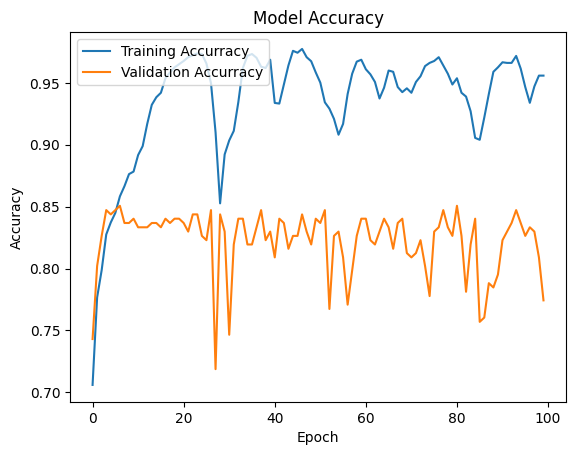

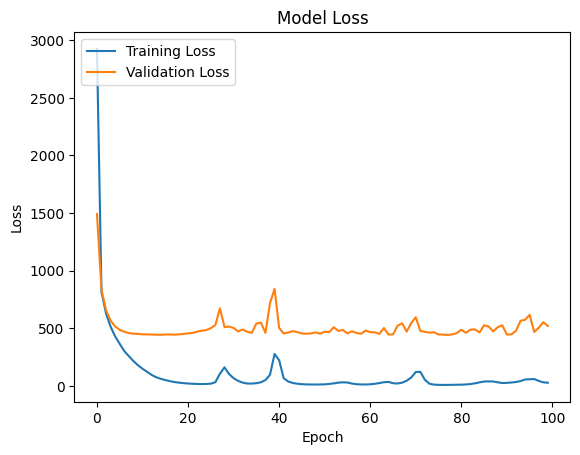

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Number-Plate-Recognition-Model/DenseNet201_model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accurracy', 'Validation Accurracy'], loc='upper left')
plt.show()

# Plot the loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()
